# Recurrent Neural Networks with Pytorch

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from IPython.display import Image

## LSTM Network

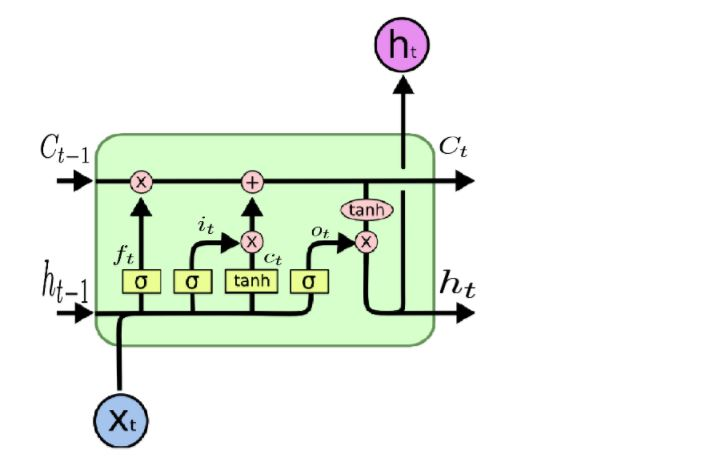

In [3]:
Image('https://www.stratio.com/wp-content/uploads/2017/10/6-1.jpg')

In brief, there is an operation to forget the old outputput based on the new input. There is an operation to generate new output based on the hidden state and the new input. There is an operation to incorporate the new output into in the new hidden state.

## Encoder - Decoder Network

Basically put two LSTM cells on top of each other. You can convert one sequence into another sequence and this has a particular natural anology in translation. The encoded output of the network is the 'meaning' of the words and the decoded output is the translation.

We can deal the inputs and outputs of variable length by using a start token and an end token.

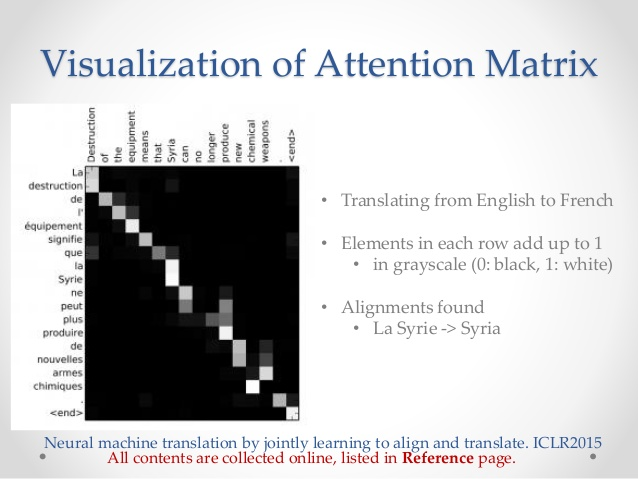

In [4]:
Image('https://image.slidesharecdn.com/rnnintro2-161020134201/95/a-brief-introduction-on-recurrent-neural-network-and-its-application-20-638.jpg')

This kind of alignment matrix will tell us what is activated in the output compared what the input was. Plus in french can mean 'more' or 'no longer' or 'longer' or 'add'. We see that produire has a direct translation and therefore gets a stronger activation than plus gets from the same word.

Likewise, predicting words from an image should give an activation on the parts of the image that contribute to that prediction.

Attention is where we use the input encoder LSTM layers to process some encoded input and concatenate it with a hidden state which is passed to the output LSTM cells. Every time an output LSTM decodes some output, we take an operator which does element wise multiplication with the compressed representation of the encoding LSTM cells.

## Reading in movie data

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

In [6]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [7]:
assert(unicodeToAscii('Montr√©al') == 'Montreal')

In [8]:
cwd = 'D:/Pytorch Data/cornell_movie_dialogs/'

In [9]:
lines_path = cwd + 'movie_lines.txt'
conv_path = cwd + 'movie_conversations.txt'

In [10]:
with open(lines_path) as file:
    movie_lines = file.readlines()
for line in movie_lines[:8]:
    print(line)

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?

L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.

L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow

L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.

L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No



In [11]:
def extractSplitLine(split_line, line_fields, first_col_id = False):
    if len(split_line) != len(line_fields):
        print('Warning: line', split_line, 'is the wrong length!')
        return
    line_dict = {}
    line_pos = 1 if first_col_id else 0
    for field in line_fields[line_pos:]:
        line_dict[field] = split_line[line_pos]
        line_pos += 1
    return line_dict

def convertLinesToDfs(line_fields, input_lines, separator, first_col_id = False): # boolean makes function dirty
    data_lines = {}
    line_id = 0
    for line in input_lines:
        split_line = line.split(separator)
        line_id = split_line[0] if first_col_id else line_id + 1
        line_dict = extractSplitLine(split_line, line_fields, first_col_id)
        if not line_dict: continue
        data_lines[line_id] = line_dict
    return pd.DataFrame.from_dict(data_lines, orient = 'index')

In [12]:
line_fields = ["lineId", "charId", "movieId", "charName", "text"]
separator = " +++$+++ "
movie_line_df = convertLinesToDfs(line_fields, movie_lines, separator, True)
del movie_lines

In [13]:
movie_line_df.head()

charId movieId charName  \
L1000      u11      m0   WALTER   
L10000   u3525    m232  LINDSEY   
L100000  u4168    m278   JOANNE   
L100001  u4166    m278  DULANEY   
L100002  u4168    m278   JOANNE   

                                                      text  
L1000    Oh, Christ.  Don't tell me you've changed your...  
L10000   Oh... chamber runs.  Uh huh, that's good.  Wel...  
L100000                                              No.\n  
L100001  Then why did you go see Mr. Koehler in the fir...  
L100002                            Because he called me.\n

In [14]:
with open(conv_path) as file:
    conv_lines = file.readlines()
for line in conv_lines[:8]:
    print(line)

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']



In [15]:
line_fields = ["charId1", "charId2", "movieId", "conversation"]
conv_line_df = convertLinesToDfs(line_fields, conv_lines, separator)
del conv_lines

In [16]:
conv_line_df.head()

charId1 charId2 movieId                        conversation
1      u0      u2      m0  ['L194', 'L195', 'L196', 'L197']\n
2      u0      u2      m0                  ['L198', 'L199']\n
3      u0      u2      m0  ['L200', 'L201', 'L202', 'L203']\n
4      u0      u2      m0          ['L204', 'L205', 'L206']\n
5      u0      u2      m0                  ['L207', 'L208']\n

In [17]:
def processMovieLine(line_string):
    line_string = unicodeToAscii(line_string)
    line_string = line_string.lower()
    line_string = re.sub(r'[ ]', ',', line_string)
    line_string = re.sub(r'[^a-z,!?.]', '', line_string)
    line_string = re.sub(r'[!]', ',!', line_string)
    line_string = re.sub(r'[?]', ',?', line_string)
    line_string = re.sub(r'[.]', ',.', line_string)
    line_string = re.sub(r',,', ',', line_string)
    return line_string.split(',')
processMovieLine(movie_line_df.iloc[5]["text"])

['hi', 'joe', '.']

In [18]:
movie_line_df['text'] = movie_line_df['text'].apply(processMovieLine)

In [19]:
def processConvLine(conv_string):
    conv_string = re.sub(r'[^,A-Za-z0-9]', '', conv_string)
    return conv_string.split(',')
processConvLine(conv_line_df.iloc[5]['conversation'])

['L271', 'L272', 'L273', 'L274', 'L275']

In [20]:
conv_line_df['conversation'] = conv_line_df['conversation'].apply(processConvLine)

In [21]:
def getAllLinesFromConversations(conversation_dict):
    lines_arr = []
    for conv_list in conversation_dict.values():
        lines_arr.extend(conv_list)
    return lines_arr

def fillUpBatchLinePairs(lines_slice, conv_slice, current_id):
    batch_dict = {}
    for conv in conv_slice.values():
        for j in range(len(conv) - 1):
            line_dict = {}
            line_dict['input'] = lines_slice[conv[j]]
            line_dict['truth'] = lines_slice[conv[j + 1]]
            batch_dict[current_id] = line_dict
            current_id += 1
    return current_id, batch_dict

def getBatchRange(i, batch_size, max_len):
    return range(i * batch_size, min((i+1) * batch_size, max_len))

def makeAllConversationPairs(movie_line_df, conv_line_df, batch_size = 100):
    n_conversations = len(conv_line_df.index)
    n_batches = (n_conversations + batch_size - 1) // batch_size
    data_lines = {}
    current_id = 0
    for i in range(n_batches):
        batch_range = getBatchRange(i, batch_size, n_conversations)
        conv_slice = conv_line_df['conversation'].iloc[batch_range].to_dict()
        lines_included = getAllLinesFromConversations(conv_slice)
        lines_slice = movie_line_df['text'].loc[lines_included].to_dict()
        current_id, batch_dict = fillUpBatchLinePairs(lines_slice, conv_slice, current_id)
        data_lines.update(batch_dict)
    return pd.DataFrame.from_dict(data_lines, orient = 'index')

In [22]:
conv_data_df = makeAllConversationPairs(movie_line_df, conv_line_df)

In [23]:
total_len = 0
for conv_list in conv_line_df['conversation']:
    total_len += len(conv_list)
    total_len -= 1
print(total_len)
assert(total_len == len(conv_data_df))

221616


## Process Vocabulary

In [24]:
conv_data_df.head()

input  \
0  [can, we, make, this, quick, ?, roxanne, korri...   
1  [well, i, thought, wed, start, with, pronuncia...   
2  [not, the, hacking, and, gagging, and, spittin...   
3  [youre, asking, me, out, ., thats, so, cute, ....   
4  [no, no, its, my, fault, we, didnt, have, a, p...   

                                               truth  
0  [well, i, thought, wed, start, with, pronuncia...  
1  [not, the, hacking, and, gagging, and, spittin...  
2  [okay, ., ., ., then, how, bout, we, try, out,...  
3                                    [forget, it, .]  
4                                       [cameron, .]

In [25]:
last_train_index = int(len(conv_data_df) * 0.9)

In [129]:
SPAM_TOKEN = 0
END_TOKEN = 1
FLUFF_TOKEN = 2

class Vocabulary:
    def __init__(self, name, last_train, batch_size = 100, stop_words = ['.', '?', '!']):
        self.name = name
        self.last_train = last_train
        self.batch_size = batch_size
        self.stop_words = stop_words
        self.resetDictionaries()
        
    def resetDictionaries(self):
        self.word_2_index = {}
        self.word_2_count = {}
        self.index_2_word = {SPAM_TOKEN:'_spam_', END_TOKEN:'_end_', FLUFF_TOKEN:'_fluff_'}
        self.nr_words = 3
        
    def addEntry(self, entry):
        for word in entry:
            if word in self.word_2_index.keys():
                self.word_2_count[word] += 1
            else:
                self.word_2_index[word] = self.nr_words
                self.index_2_word[self.nr_words] = word
                self.word_2_count[word] = 1
                self.nr_words += 1
            if word in self.stop_words: break
                
    def addAllEntries(self, df, col):
        n_batches = (self.last_train + self.batch_size - 1) // self.batch_size
        for k in range(n_batches):
            batch_range = getBatchRange(k, self.batch_size, self.last_train)
            conv_slice = df[col].iloc[batch_range].to_dict()
            for entry in conv_slice.values():
                self.addEntry(entry)
    
    def countEntry(self, entry):
        entry_count = 0
        for word in entry:
            if word in self.word_2_index.keys():
                entry_count += 1
                if word in self.stop_words: break
        return entry_count
    
    def getLongestSentence(self, df):
        n_batches = (len(df) + self.batch_size - 1) // self.batch_size
        max_count = 0
        for col in df.columns:
            for k in range(n_batches):
                batch_range = getBatchRange(k, self.batch_size, len(df))
                conv_slice = df[col].iloc[batch_range].to_dict()
                for entry in conv_slice.values():
                    entry_count = self.countEntry(entry)
                    if entry_count > max_count: max_count = entry_count
        return max_count
                
    def removeBelowThreshold(self, thresh):
        new_word_2_index = {}
        new_word_2_count = {}
        new_index_2_word = {SPAM_TOKEN:'_spam_', END_TOKEN:'_end_', FLUFF_TOKEN:'_fluff_'}
        k = 3
        current_index = 3
        for k in range(3, self.nr_words):
            word = self.index_2_word[k]
            word_count = self.word_2_count[word]
            if word_count > thresh:
                new_word_2_index[word] = current_index
                new_index_2_word[current_index] = word
                new_word_2_count[word] = word_count
                current_index += 1
        self.word_2_index = new_word_2_index
        self.word_2_count = new_word_2_count
        self.index_2_word = new_index_2_word
        self.nr_words = current_index
        
    def tokenizeEntry(self, out_tensor, entry, current_ind):
        w_ind = 0
        entry_len = len(entry)
        sentence_len = out_tensor.shape[0]
        while w_ind < sentence_len:
            if not w_ind < entry_len: break
            word = entry[w_ind]
            if word in self.word_2_count.keys():
                out_tensor[w_ind, current_ind] = self.word_2_index[entry[w_ind]]
            else:
                out_tensor[w_ind, current_ind] = SPAM_TOKEN
            w_ind += 1
            if word in self.stop_words: break
        if w_ind < sentence_len:
            out_tensor[w_ind, current_ind] = END_TOKEN
            w_ind += 1
        while w_ind < sentence_len:
            out_tensor[w_ind, current_ind] = FLUFF_TOKEN
            w_ind += 1
        
    def getTokenizedBatch(self, out_tensor, df, col, start_ind):
        if out_tensor.shape[1] != self.batch_size: print('Input tensor has wrong length!'); return
        n_batches = (len(df) + self.batch_size - 1) // self.batch_size
        current_ind = 0
        batch_range = getBatchRange(start_ind, self.batch_size, len(df))
        conv_slice = df[col].iloc[batch_range].to_dict()
        for entry in conv_slice.values():
            self.tokenizeEntry(out_tensor, entry, current_ind)
            current_ind += 1
                
    def printTensorRow(self, in_tensor):
        sentence = ''
        first_word = True
        for embedded_word in in_tensor:
            word = self.index_2_word[int(embedded_word)]
            if first_word:
                first_word = False
                word = word[0].upper() + word[1:]
            else:
                sentence += ' '
            sentence += word
        sentence = re.sub(r' \!', '!', sentence)
        sentence = re.sub(r' \?', '?', sentence)
        sentence = re.sub(r' \.', '.', sentence)
        return sentence
    
    def plotFrequencyHist(self, cut_off):
        freq_dist = [val for val in self.word_2_count.values() if val < cut_off]
        total_freq = sum(self.word_2_count.values())
        if total_freq > 0: total_freq = sum(freq_dist)/total_freq
        sns.distplot(freq_dist, color='y', kde = False)
        plt.title(label = "Showing {}% of all words".format(np.round(total_freq * 100, 1)))
        plt.show()

In [130]:
cut_off = 4

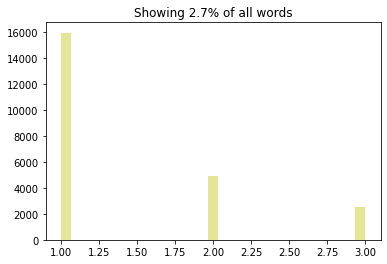

In [131]:
movie_vocab = Vocabulary('MOVIE_CONV', last_train_index)
movie_vocab.addAllEntries(conv_data_df, 'input')
movie_vocab.plotFrequencyHist(cut_off)

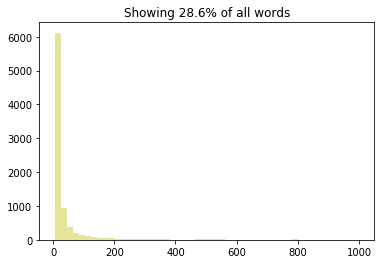

In [132]:
movie_vocab.removeBelowThreshold(cut_off)
movie_vocab.plotFrequencyHist(1000)

In [133]:
vocab_size = movie_vocab.nr_words; print(vocab_size)

8617


In [134]:
longest_sentence = movie_vocab.getLongestSentence(conv_data_df); print(longest_sentence)

104


In [135]:
sentence_limit = 20
batch_size = movie_vocab.batch_size

In [136]:
data_input = torch.zeros((sentence_limit, batch_size), dtype = torch.float32)

In [137]:
data_true = torch.zeros((sentence_limit, batch_size), dtype = torch.float32)

In [138]:
movie_vocab.getTokenizedBatch(data_input, conv_data_df, 'input', 0)

In [139]:
movie_vocab.printTensorRow(data_input[:, 9])

'Gosh if only we could find kat a boyfriend. _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [140]:
movie_vocab.getTokenizedBatch(data_true, conv_data_df, 'truth', 0)

In [141]:
movie_vocab.printTensorRow(data_true[:, 9])

'Let me see what i can do. _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [142]:
assert(np.linalg.norm(np.array(data_input.shape) - (sentence_limit, batch_size) == 0.))

In [143]:
data_input.device

device(type='cpu')

## Building the Model

This module will define the encoder part of the model which can be stacked on top of one another. Since it is bi-directional the sum of the two outputs can be added to get the information from two points of view.

In [144]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers = 1, dropout = 0):
        super().__init__() # EncoderRNN, self
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.dropout = 0 if n_layers == 1 else dropout
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout = self.dropout, bidirectional=True)
        
    def forward(self, input_batch, hidden = None):
        outputs, hidden = self.gru(input_batch, hidden)
        # Sum birdirectional parts of the network
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:] 
        ## torch.nn.utils.rnn.pack_padded_sequence should work better... as it is more embedded and faster
        return outputs, hidden